In [1]:
import numpy as np
from numpy import transpose as tr, conjugate as co
from scipy.linalg import expm, svd
from scipy.sparse.linalg import eigsh, LinearOperator
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

### Useful functions

In [2]:
def dot(A,B):
    """ Does the dot product like np.dot, but preserves the shapes also for singleton dimenstions """
    s1 = A.shape
    s2 = B.shape
    return np.dot(A,B).reshape((s1[0],s2[1]))

def left_canonize(M1,M2,return_S = False):
    """ Left normalizes M1 into A matrix, M2 looses its canonization"""
    s, da, db = M1.shape
    U, S, Vh = svd(M1.reshape((s*da,db)))
    U      = U.reshape((s,da,U.shape[1]))[:,:,:db]
    M2     = np.tensordot(dot(np.diag(S[:db]),Vh[:db,:]),M2,axes=((1),(1)))
    if return_S:
        return U, M2, S
    else:
        return U, M2

def right_canonize(M1,M2,return_S = False):
    """ Right normalizes M2 into B matrix, M1 looses its canonization """
    s, da, db = M2.shape
    U, S, Vh = svd(M2.transpose((1,0,2)).reshape((da,s*db)))
    Vh     = Vh.reshape((Vh.shape[0],s,db)).transpose((1,0,2))[:,:da,:]
    M1     = np.tensordot(M1,dot(U[:,:da],np.diag(S[:da])),axes=((2),(0)))
    if return_S:
        return M1, Vh, S
    else:
        return M1, Vh
    
def add_site_to_R(Rexp,M,W):
    Rexp = np.tensordot(M.conj(),Rexp,axes=((2),(0)))
    Rexp = np.tensordot(W,Rexp,axes=((0,3),(0,2)))
    Rexp = np.tensordot(M,Rexp,axes=((0,2),(0,3)))
    Rexp = np.transpose(Rexp,(2,1,0))
    return Rexp

def add_site_to_L(Lexp,M,W):
    Lexp = np.tensordot(M.conj(),Lexp,axes=((1),(0)))
    Lexp = np.tensordot(W,Lexp,axes=((0,2),(0,2)))
    Lexp = np.tensordot(M,Lexp,axes=((0,1),(0,3)))
    Lexp = np.transpose(Lexp,(2,1,0))
    return Lexp

def Hpsi(L,W,R,M):
    """
    Calculates the "matrix-vector product" at arbitrary site from 
    L ... L-expression, belonging to the "matrix"
    W ... W-array at site l, belonging to the "matrix"
    R ... R-expression, belonging to the "matrix"
    M ... M-array, the "vector"
    """
    if len(M.shape)==1:
        flatten = True
        M = np.reshape(M,(s,L.shape[0],R.shape[0]))
    elif len(M.shape)==3:
        flatten = False
    else:
        raise ValueError('Unknown format for M')
    hpsi = np.tensordot(L,M,axes=((2),(1)))
    hpsi = np.tensordot(W,hpsi,axes=((1,2),(2,1)))
    hpsi = np.tensordot(hpsi,R,axes=((1,3),(1,2)))
    if flatten:
        return hpsi.flatten()
    else:
        return hpsi

### Definitions and construction of MPO

In [3]:
J   = 1.
L   = 40     # Length of chain
s   = 2      # Local dimension of Hilbert space
chi = 60     # The maximum matrix dimension, from which on the matrices are truncated
nmax = 10000 # Maximum number of iterations

## Generate the MPO for the Heisenberg model
W = []
## some operators
Z = np.zeros((2,2,1,1))

Id = np.zeros((2,2,1,1))
Id[0,0,0,0] = 1.
Id[1,1,0,0] = 1.

Sz = np.zeros((2,2,1,1))
Sz[0,0,0,0] = +0.5
Sz[1,1,0,0] = -0.5

Sp = np.zeros((2,2,1,1))
Sp[0,1,0,0] = 1.

Sm = np.zeros((2,2,1,1))
Sm[1,0,0,0] = 1.

W.append(np.concatenate((Z,J/2*Sm,J/2*Sp,J*Sz,Id),axis=3))
for i in range(1,L-1):
    Wi = np.concatenate((
            np.concatenate((Id,Z,Z,Z,Z),axis=3),
            np.concatenate((Sp,Z,Z,Z,Z),axis=3),
            np.concatenate((Sm,Z,Z,Z,Z),axis=3),
            np.concatenate((Sz,Z,Z,Z,Z),axis=3),
            np.concatenate((Z,J/2*Sm,J/2*Sp,J*Sz,Id),axis=3),
        ),axis=2)
    W.append(Wi)
W.append(np.concatenate((Id,Sp,Sm,Sz,Z),axis=2))

### Random guess as groundstate

In [8]:
## random starting configuration
M = [np.random.standard_normal((s,min(chi,s**i,s**(L-i)),min(chi,s**(i+1),s**(L-1-i)))) for i in range(L)]

## need a right canonized MPS
for i in range(L-1,0,-1):
    M[i-1], M[i] = right_canonize(M[i-1],M[i])
## normalization, throw away left part
_, M[0] = right_canonize(np.ones((1,1,1)),M[0])

### DMRG sweeps

In [9]:
## get initial R expression
Rexp = [np.ones((1,1,1))]
for i in range(1,L):
    Rexp.append(add_site_to_R(Rexp[i-1],M[-i],W[-i]))
    
enold = 0
    
for n in range(nmax):
    ## right sweep
    Lexp = [np.ones((1,1,1))]
    for i in range(L-1):
        print('.', end="")
        dD2 = s*Lexp[i].shape[0]*Rexp[L-1-i].shape[0]
        Hop = LinearOperator((dD2,dD2),matvec= lambda M: Hpsi(Lexp[i],W[i],Rexp[L-1-i],M))
        en,V = eigsh(Hop,k=1,v0=M[i].flatten(),tol=1e-3 if n < 2 else 0)
        M[i]  = V.reshape((s,Lexp[i].shape[0],Rexp[L-1-i].shape[0]))
        M[i], M[i+1]   = left_canonize(M[i],M[i+1])
        Lexp.append(add_site_to_L(Lexp[i],M[i],W[i]))
    print('')

    ## left sweep
    Rexp = [np.ones((1,1,1))]
    for i in range(L-1,0,-1):
        print('.', end="")
        dD2 = s*Lexp[i].shape[0]*Rexp[L-1-i].shape[0]
        Hop = LinearOperator((dD2,dD2),matvec = lambda M: Hpsi(Lexp[i],W[i],Rexp[L-1-i],M))
        en,V = eigsh(Hop,k=1,v0=M[i].flatten(),tol=1e-3 if n < 2 else 0)
        M[i]  = V.reshape((s,Lexp[i].shape[0],Rexp[L-1-i].shape[0]))
        M[i-1], M[i]   = right_canonize(M[i-1],M[i])
        Rexp.append(add_site_to_R(Rexp[L-1-i],M[i],W[i]))
    print('')
        
    # === check convergence ===
    print(n,'dE = ',abs(en-enold))
    if abs(en-enold) < 1e-8:
        print("Converged after "+str(n)+" sweeps!")
        print("Ground-state energy: " + str(en))
        break
    enold = en
    # === check convergence ===



.......................................
.......................................
0 dE =  [ 17.54144864]
.......................................
.......................................
1 dE =  [  1.52946031e-05]
.......................................
.......................................
2 dE =  [  9.36516908e-06]
.......................................
.......................................
3 dE =  [  2.37690756e-10]
Converged after 3 sweeps!
Ground-state energy: [-17.5414733]


### Measure Entanglement Entropy

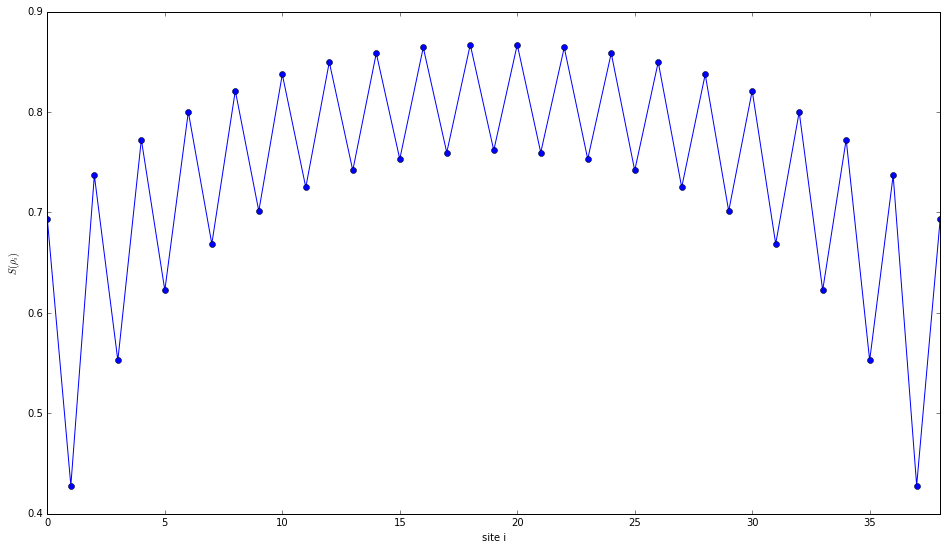

In [6]:
ent = np.zeros((L-1))
## measurment assumes right canonized MPS!!!
for j in range(L-1):
    M[j], M[j+1], S = left_canonize(M[j],M[j+1], return_S = True)
    ent[j] = -np.sum(S**2*np.log(S**2))


plt.figure()
plt.plot(ent,'-o')
plt.xlabel('site i')
plt.ylabel(r'$S(\rho_i)$')
plt.xlim([0,L-2])
plt.show()